In [7]:
#--- Library Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import load_results
from ema_workbench.analysis import dimensional_stacking

In [2]:
# --- Configuration ---
# Path to the saved exploratory experiment results
RESULTS_FILE_PATH = "../experimental data/pf_3_exploratory_runs_levers_as_factors.tar.gz"

# Define the percentile for "desirable" outcomes (e.g., 0.10 for the best 10%)
DESIRABLE_PERCENTILE_deaths = 0.10
DESIRABLE_PERCENTILE_costs = 0.30
DESIRABLE_PERCENTILE_rfr = 0.70

In [3]:
# Outcome column names relevant to the client (based on Problem Formulation 4 outputs)
# These should be the exact names as they appear after loading/processing the results.
# PF3 sums outcomes over specific dikes.
# Define the Dike Ring ID for Grossel (ensure this matches your model's naming)
Grossel_DIKE_RING_ID = "A.4" #ID extracted because Deventer is lcoation of interest 5 from the Course Manual

# Outcome column names relevant to the client (from Problem Formulation 3 outputs)
CASUALTIES_COL = f'{Grossel_DIKE_RING_ID}_Expected Number of Deaths'
TOTAL_COSTS_COL = f'{Grossel_DIKE_RING_ID} Total Costs' # PF3 defines this as EAD + Dike Inv. for the specific dike
RFR_COSTS_COL_SYSTEMWIDE = 'RfR Total Costs' # This is a system-wide outcome in PF3


In [4]:
# --- 1. Load EMA Workbench Results ---
print(f"INFO: Loading results from: {RESULTS_FILE_PATH}")
try:
    # experiments_array is a NumPy structured array
    # raw_outcomes_dict contains 1D NumPy arrays for PF3 ScalarOutcomes
    experiments_array, raw_outcomes_dict = load_results(RESULTS_FILE_PATH)
    print(f"INFO: Successfully loaded results.")
    print(f"INFO: experiments_array shape: {experiments_array.shape}")
    print(f"INFO: raw_outcomes_dict contains {len(raw_outcomes_dict)} outcomes.")
    # For debugging, print shapes of raw outcomes:
    # for k, v in raw_outcomes_dict.items():
    #     print(f"  Raw outcome '{k}' shape: {np.shape(v)}, dtype: {v.dtype}")
except FileNotFoundError:
    print(f"ERROR: Results file not found at {RESULTS_FILE_PATH}. Please check the path.")
    raise 
except Exception as e:
    print(f"ERROR: An unexpected error occurred while loading results: {e}")
    raise

#Check if the desired columns for A.5 are present in the raw_outcomes_dict


INFO: Loading results from: ../experimental data/pf_3_exploratory_runs_levers_as_factors.tar.gz
INFO: Successfully loaded results.
INFO: experiments_array shape: (2000, 53)
INFO: raw_outcomes_dict contains 12 outcomes.


In [5]:
# --- 2. Convert Results to Pandas DataFrames ---

# Convert experiments array to DataFrame
try:
    experiments_df = experiments_array
    print(f"INFO: Converted experiments_array to DataFrame. Shape: {experiments_df.shape}")
except Exception as e:
    print(f"ERROR: Failed to convert experiments_array to DataFrame: {e}")
    raise

# Convert outcomes dictionary to DataFrame
# For PF3, ScalarOutcome with the `sum_over` function should result in 1D arrays in raw_outcomes_dict (one scalar value per scenario for each outcome instead of 3 values, one for each panning step).
try:
    outcomes_df = pd.DataFrame(raw_outcomes_dict)
    print(f"INFO: Converted raw_outcomes_dict to DataFrame. Shape: {outcomes_df.shape}")
    # To verify columns:
    # print("\nINFO: Columns in outcomes_df:")
    # print(outcomes_df.columns.tolist())
except ValueError as e:
    print(f"ERROR: ValueError during DataFrame creation from raw_outcomes_dict: {e}")
    print("  This typically means arrays within raw_outcomes_dict are not 1D or have inconsistent lengths.")
    print("  Double-check that the results file was generated using Problem Formulation 3,")
    print("  and that the `sum_over` function in problem_formulation.py correctly produces scalar outputs.")
    print("  Content of raw_outcomes_dict keys and shapes:")
    for k_debug, v_arr_debug in raw_outcomes_dict.items():
        print(f"    {k_debug}: shape {np.shape(v_arr_debug)}, dtype {getattr(v_arr_debug, 'dtype', 'N/A')}")
    raise
except Exception as e:
    print(f"ERROR: Failed to convert raw_outcomes_dict to DataFrame: {e}")
    raise

# Verify that the required outcome columns for Grossel and system-wide RfR exist
required_outcome_cols_for_prim = [CASUALTIES_COL, TOTAL_COSTS_COL, RFR_COSTS_COL_SYSTEMWIDE]
missing_cols = [col for col in required_outcome_cols_for_prim if col not in outcomes_df.columns]
if missing_cols:
    print(f"ERROR: Required outcome column(s) for PRIM not found in outcomes_df: {missing_cols}")
    print(f"Available outcome columns: {outcomes_df.columns.tolist()}")
    print(f"Ensure Grossel_DIKE_RING_ID ('{Grossel_DIKE_RING_ID}') is correct and matches PF3 output naming conventions.")
    raise KeyError(f"Outcome column(s) missing: {missing_cols}.")


INFO: Converted experiments_array to DataFrame. Shape: (2000, 53)
INFO: Converted raw_outcomes_dict to DataFrame. Shape: (2000, 12)


In [13]:
# --- 3. Define the "Outcome of Interest" (y) for PRIM ---
# Desirable scenarios: where Grossel casualties, Grossel total costs are low, AND system-wide Grossel RfR costs are high

threshold_casualties = outcomes_df[CASUALTIES_COL].quantile(DESIRABLE_PERCENTILE_deaths)
threshold_total_costs = outcomes_df[TOTAL_COSTS_COL].quantile(DESIRABLE_PERCENTILE_costs)
threshold_rfr_costs_ = outcomes_df[RFR_COSTS_COL_SYSTEMWIDE].quantile(DESIRABLE_PERCENTILE_rfr)

#print(f"\n--- Defining Desirable Outcome Thresholds (Lowest {DESIRABLE_PERCENTILE*100:.0f}th Percentile) ---")
print(f"Threshold for '{CASUALTIES_COL}' (low): <= {threshold_casualties:.4f}")
print(f"Threshold for '{TOTAL_COSTS_COL}' (low): <= {threshold_total_costs:.2e}")
print(f"Threshold for '{RFR_COSTS_COL_SYSTEMWIDE}' (low): >= {threshold_rfr_costs_:.2e}")

# Create the boolean Series y: True if all conditions for desirable outcomes are met
y_desirable_deaths = outcomes_df[CASUALTIES_COL] <= threshold_casualties
y_desirable_costs = outcomes_df[TOTAL_COSTS_COL] <= threshold_total_costs
y_desirable_rfr = outcomes_df[RFR_COSTS_COL_SYSTEMWIDE] >= threshold_rfr_costs_

num_desirable_cases = np.sum(y_desirable_deaths & y_desirable_costs & y_desirable_costs)

if num_desirable_cases == 0:
    print("WARNING: No scenarios meet all desirable criteria with the current thresholds. "
          "PRIM analysis cannot proceed. Consider relaxing thresholds or checking data.")
# elif num_desirable_cases < max(50, 0.1 * total_cases) : # Heuristic for minimum cases for PRIM
#     print(f"WARNING: Very few ({num_desirable_cases}) scenarios meet all desirable criteria. "
#           "PRIM results might be unstable. Consider relaxing thresholds or increasing DESIRABLE_PERCENTILE.")


Threshold for 'A.4_Expected Number of Deaths' (low): <= 0.0000
Threshold for 'A.4 Total Costs' (low): <= 3.38e+07
Threshold for 'RfR Total Costs' (low): >= 1.25e+09


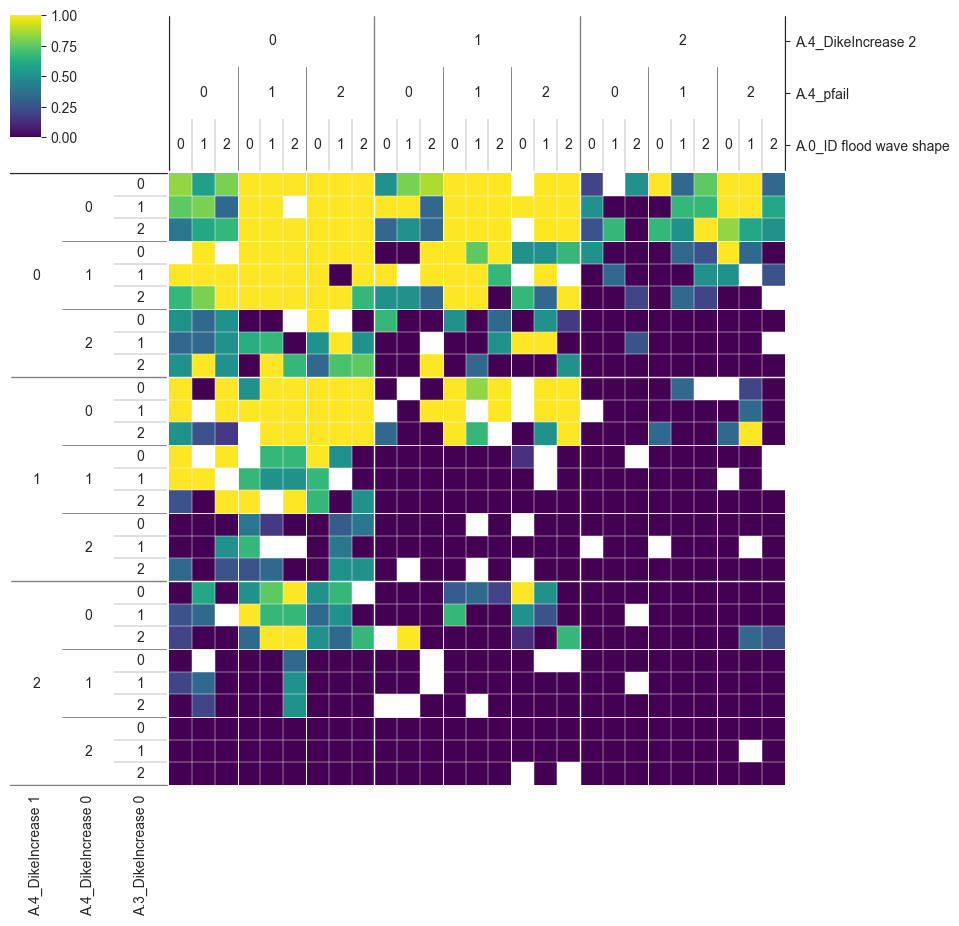

In [8]:
dimensional_stacking.create_pivot_plot(experiments_df,np.array(y_desirable_costs))
plt.show()

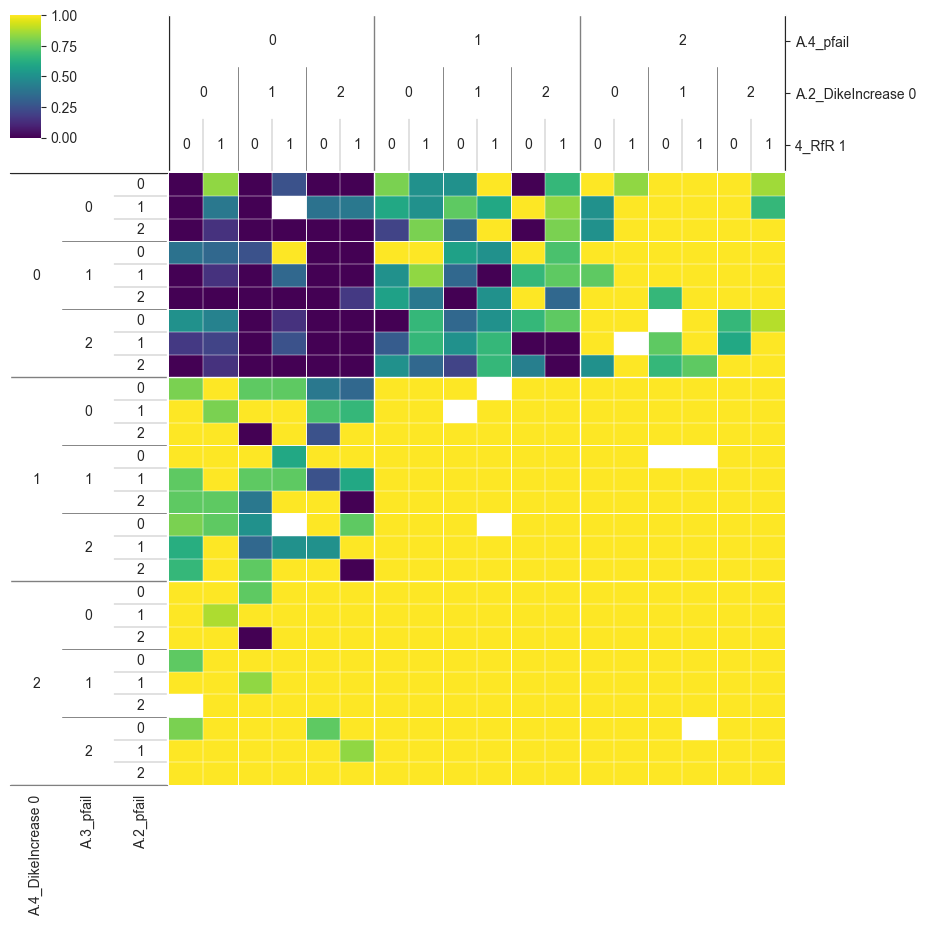

In [9]:
dimensional_stacking.create_pivot_plot(experiments_df,np.array(y_desirable_deaths))
plt.show()

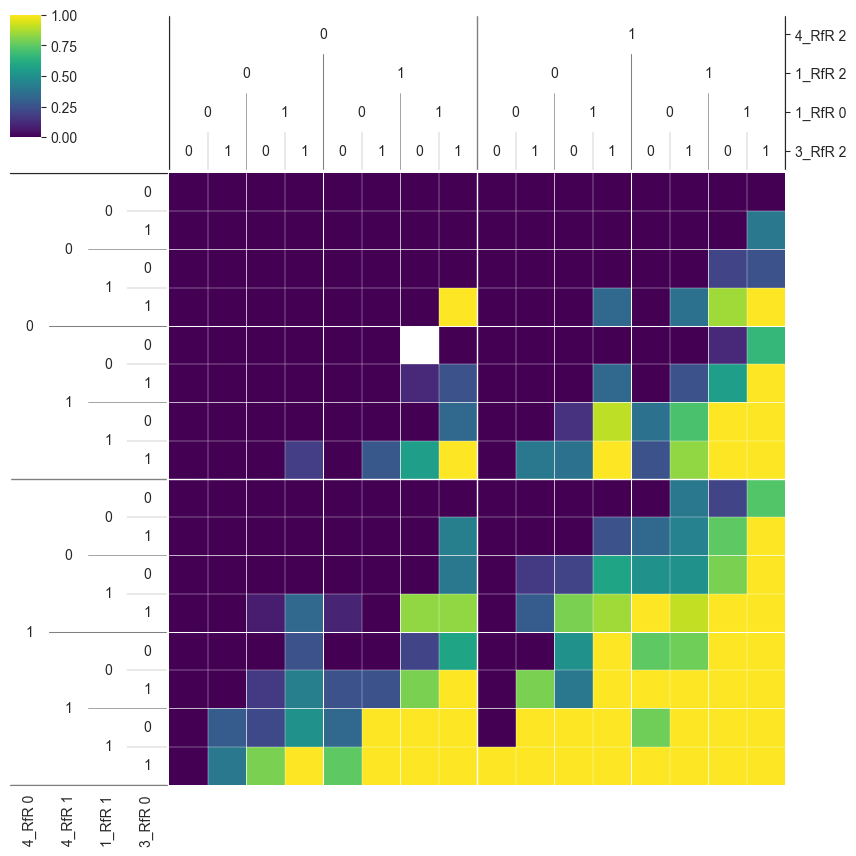

In [16]:
dimensional_stacking.create_pivot_plot(experiments_df,np.array(y_desirable_rfr), nr_levels=4)
plt.show()

Analyzing combined outcomes for Grossel using PRIM...


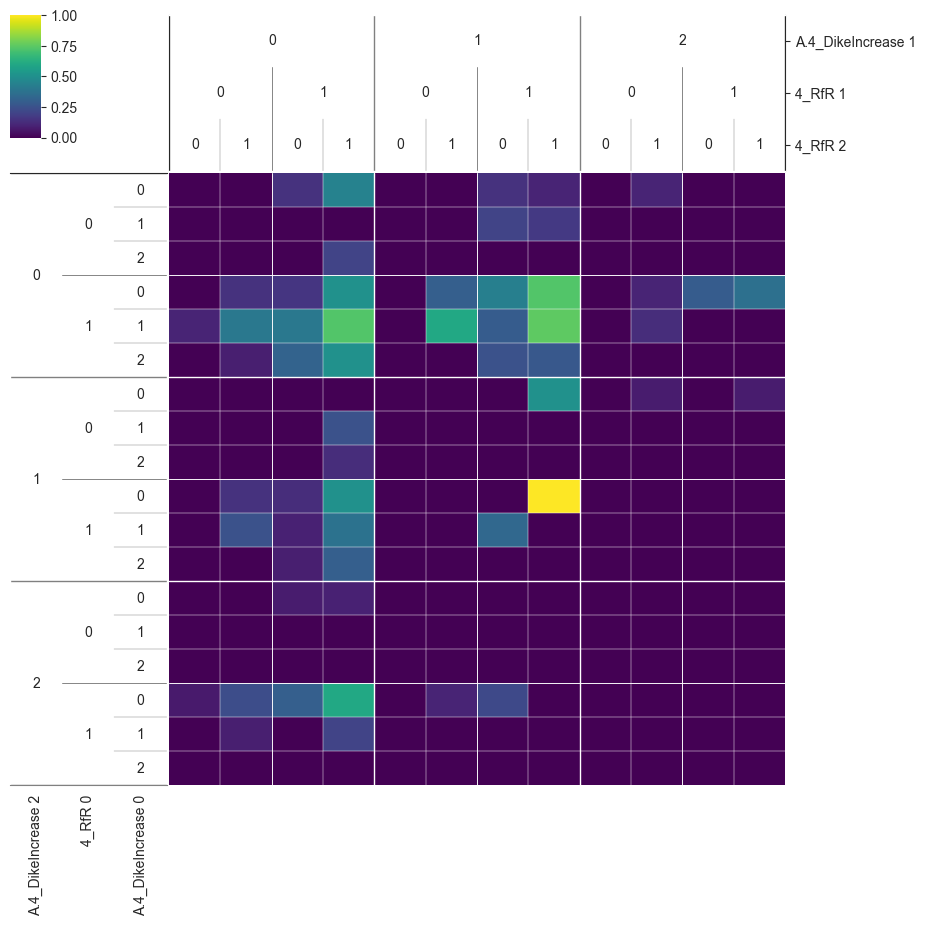

In [17]:
#--- 7. PRIM Analysis --- Combined
print("Analyzing combined outcomes for Grossel using PRIM...")
# Create a combined boolean Series for all three outcomes
y_combined = y_desirable_rfr & y_desirable_deaths & y_desirable_costs
if y_combined.sum() == 0:
    print("WARNING: No scenarios meet all combined desirable criteria. "
          "PRIM analysis cannot proceed. Consider relaxing thresholds or checking data.")
# elif y_combined.sum() < max(50, 0.5 * total_cases): # Heuristic for minimum cases for PRIM
#     print(f"WARNING: Very few ({y_combined.sum()}) scenarios meet all combined desirable criteria. "
#           "PRIM results might be unstable. Consider relaxing thresholds or increasing DESIRABLE_PERCENTILE.")
# Perform PRIM analysis on the combined outcomes
dimensional_stacking.create_pivot_plot(experiments_df,np.array(y_combined))
plt.show()

### Main conclusions

Dimensional stacking confirms unlikeliness of deaths. However, it also shows that `A.4_Dikeincrease_0` and `A.4_pfail` are fundamental in determining such outcome. Lower values of those two variables coud lead to an undesired increase in deaths.

Difficulty in achieving desired outcome in total cost is also highlighted by Dimensional stacking. A similar pattern is shown for Deventer costs, siggesting that the main influencing factors for reducing total cost is (intuitively), lowering the increase in the local Dikes.

Achieving all three goals is highly unlikely under most scenarios.